We investigate two approaches for computing ROC-AUC in cross-validation settings: (1) fold-averaged AUC, where AUC is computed per fold and then averaged, and (2) pooled AUC, where predictions from all folds are concatenated before AUC computation. Through simulation studies on imbalanced binary classification tasks, we demonstrate that these approaches yield systematically different estimates with implications for model evaluation and selection. Our analysis follows three steps: (1) demonstrate the difference on single datasets, (2) establish statistical significance through 1,000 Monte Carlo replications, and (3) compare both strategies against true generalization performance.

We compare the following startegies to cmpute the generalization AUC in a cross-validation setting:

1. **Fold-averaged AUC**: $\text{AUC}_{\text{avg}} = \frac{1}{K} \sum_{k=1}^{K} \text{AUC}(\mathbf{y}^{(k)}, \hat{\mathbf{p}}^{(k)})$
2. **Pooled AUC**: $\text{AUC}_{\text{pooled}} = \text{AUC}(\mathbf{y}_{\text{all}}, \hat{\mathbf{p}}_{\text{all}})$

where $\mathbf{y}^{(k)}$ and $\hat{\mathbf{p}}^{(k)}$ are the true labels and predicted probabilities for fold $k$, and the subscript "all" denotes concatenation across all test folds.

## Setup

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression

from src.cv import run_cv
from src import simulations
from src.metrics import create_metrics

## Experimental Setup
We simulate binary classification tasks using a mixture of two univariate Gaussians:

- **Class 0** (negative): $X | Y=0 \sim \mathcal{N}(\mu_0, \sigma_0^2)$  
- **Class 1** (positive): $X | Y=1 \sim \mathcal{N}(\mu_1, \sigma_1^2)$

The class imbalance is controlled via the positive class ratio $\pi = P(Y=1)$.

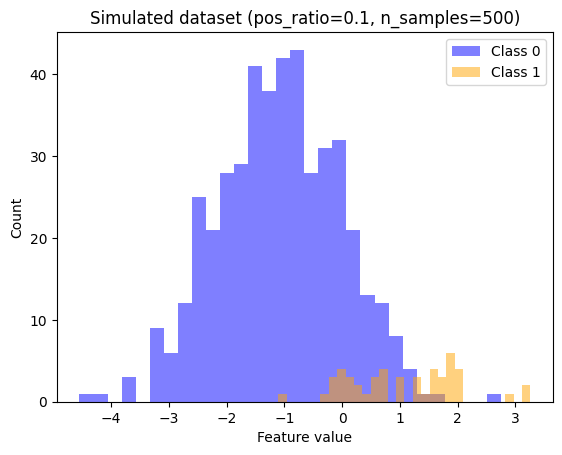

In [2]:
# set up the dataset parameters
n_samples = 500
pos_ratio = 0.1
mu0 = -1
sigma0 = 1
mu1 = 1
sigma1 = 1

# simulate
X, y = simulations.simulate_dataset(n_samples, pos_ratio, mu0, sigma0, mu1, sigma1, seed=1)

# plot the dataset
fig, ax = plt.subplots()
ax.set_title(f"Simulated dataset (pos_ratio={pos_ratio}, n_samples={n_samples})")
ax.set_xlabel("Feature value")
ax.set_ylabel("Count")
ax.hist(X[y == 0], bins=30, alpha=0.5, label="Class 0", color="blue")
ax.hist(X[y == 1], bins=30, alpha=0.5, label="Class 1", color="orange")
ax.legend()
plt.show()

We use 5-fold stratified cross-validation to ensure each fold maintains the original class distribution. For each fold, we:

1. Train a logistic regression classifier on the training partition
2. Generate predictions and probability estimates on the test partition
3. Aggregate the predictions
4. Compute fold-specific metrics (accuracy, AUC)

In [3]:
X, y = simulations.simulate_dataset(n_samples, pos_ratio, mu0, sigma0, mu1, sigma1, seed=1)

model = LogisticRegression()
metrics = create_metrics(["accuracy", "rocauc", "prcauc"])
results = run_cv(model, X, y, metrics, n_splits=5, stratified=True, random_state=1)

Further, can simulate a "true" test set to test the test set to compute the generalization error.

In [4]:
X_gen, y_gen = simulations.simulate_dataset(1000, pos_ratio, mu0, sigma0, mu1, sigma1, seed=100)

# fit the model on the full training dataset
model.fit(X, y)

# Predict and score on fresh ("generalization") data
y_pred_gen = model.predict(X_gen)
y_proba_gen = model.predict_proba(X_gen)[:, 1]

# add generalization to the results
results["generalized"] = {}
for name, function in metrics.items():
    score = function(y_gen, y_pred_gen, y_proba_gen)
    results["generalized"][name] = score

Let's look at the results:

In [5]:
results_df = pd.DataFrame(results)
print(results_df)

           average    pooled  generalized
accuracy  0.938000  0.938000     0.944000
rocauc    0.940637  0.934793     0.931445
prcauc    0.732418  0.684738     0.701778


The theoretical difference between averaged and pooled is computed as follows:

$$ AUC_{avg} - AUC_{pooled} = \frac{(K-1)}{(N_p \cdot N_n)}$$

where $N_p$ and $N_n$ are the number of positive and negative samples, respectively, and $K$ is the number of folds.

In [6]:
Np = sum(y == 1)
Nn = sum(y == 0)
K = 5
theoretical_diff = (K - 1) / (Np * Nn)
experimental_diff = results_df.loc["rocauc", "average"] - results_df.loc["rocauc", "pooled"]
print(f"Theoretical difference: {theoretical_diff:.6f}")
print(f"Experimental difference: {experimental_diff:.6f}")

Theoretical difference: 0.000181
Experimental difference: 0.005844


## Statistical Analysis
To get an idea about the statistics of this experiment, we repeat this experiment using a Monte Carlo simulation where run 1,000 independent replications. Each replication generates a new dataset with identical parameters but different random seeds.

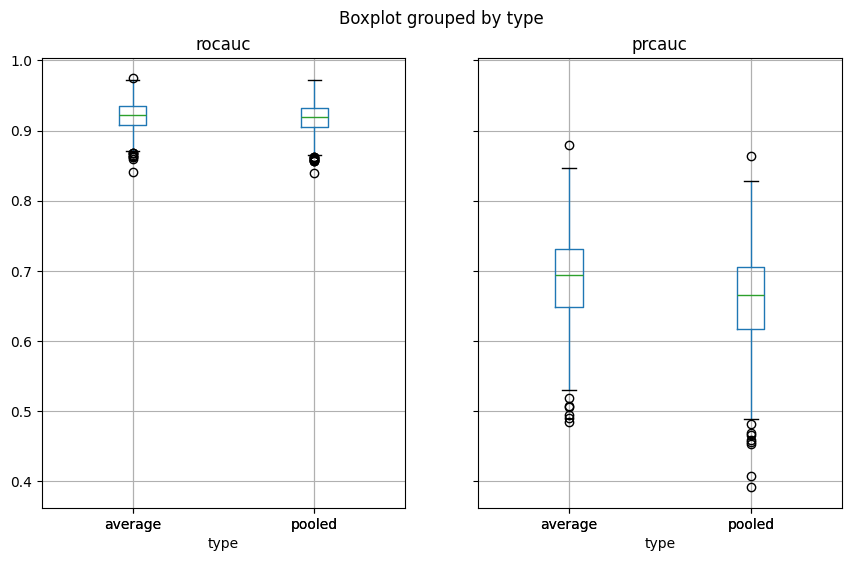

         accuracy    rocauc    prcauc
type                                 
average   0.92921  0.920799  0.689725
pooled    0.92921  0.917706  0.660379


In [ ]:
results = []
diff_aucs = []
for seed in range(1, 1001):
    # simulate new set of data
    X, y = simulations.simulate_dataset(n_samples, pos_ratio, mu0, sigma0, mu1, sigma1, seed=seed)

    # setup model
    model = LogisticRegression()
    metrics = create_metrics(["accuracy", "rocauc", "prcauc"])

    # run cv
    result = run_cv(model, X, y, metrics, n_splits=5, stratified=True, random_state=1)

    # Flatten the nested dictionary structure
    for key, metrics in result.items():
        flattened_result = {"type": key, **metrics}
        results.append(flattened_result)

    # compute the experimental difference
    df_result = pd.DataFrame(result)
    diff_auc = df_result.loc["rocauc", "average"] - df_result.loc["rocauc", "pooled"]
    diff_aucs.append(diff_auc)

# Convert the flattened results into a DataFrame
results_df = pd.DataFrame(results)

# Visualization
results_df.boxplot(column=["rocauc", "prcauc"], by="type", figsize=(10, 6))
plt.ylabel("Values")
plt.show()

mean_results = results_df.groupby("type")[["accuracy", "rocauc", "prcauc"]].mean()
print(mean_results)

# plot the distribution of differences in AUC
plt.hist(diff_aucs, bins=30, alpha=0.7, color="green")
plt.title("Distribution of differences between average and pooled AUC")
plt.xlabel("Difference (average AUC - pooled AUC)")
plt.ylabel("Frequency")


Since we repeated this expiremnt a couple of times, we can run t-test to see whether there is a stistical difference between the pooled and average strategy to estimate the generalization error.

In [8]:
import statsmodels.api as sm
from statsmodels.formula.api import ols

# Perform a t-test to compare AUC between pooled and average
# Filter the data for the two types
pooled_auc = results_df[results_df["type"] == "pooled"]["rocauc"]
average_auc = results_df[results_df["type"] == "average"]["rocauc"]

# Combine the data into a single DataFrame for analysis
comparison_df = results_df[results_df["type"].isin(["pooled", "average"])]

# Perform an ANOVA test using statsmodels
model = ols("rocauc ~ C(type)", data=comparison_df).fit()

# Print the ANOVA table
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:                 rocauc   R-squared:                       0.006
Model:                            OLS   Adj. R-squared:                  0.005
Method:                 Least Squares   F-statistic:                     11.58
Date:                Wed, 01 Oct 2025   Prob (F-statistic):           0.000680
Time:                        15:54:25   Log-Likelihood:                 4954.8
No. Observations:                2000   AIC:                            -9906.
Df Residuals:                    1998   BIC:                            -9894.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
Intercept             0.9208      0.00